In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os
import argparse
from sklearn.metrics import roc_curve as ROC
from sklearn.metrics import auc,brier_score_loss

import matplotlib
import matplotlib.pyplot as plt

from Utils.loading import *
from Utils.treino import *
from Utils.init_redes import *
from Utils.KD import *
from Utils.ensemble import *
from Utils.redes import *
from Utils.data_set import *
from Utils.cobertura import *
from Utils.graficos import *

cuda


In [2]:
if torch.cuda.is_available():
    device = 'cuda'  
else:
    device = 'cpu'
print(device)

cuda


In [3]:
data_set = "Cifar10"

if data_set == "Cifar10":
    transform_train, transform_test, batch_size, trainset, trainloader, testset, testloader, classes = cifar10()
elif data_set == "Cifar100":
    transform_train, transform_test, batch_size, trainset, trainloader, testset, testloader= cifar100()

Files already downloaded and verified
Files already downloaded and verified


In [4]:
num_cabeca = 2 # numero de cabecas da rede
hydra = init_rede("Resnet_hydra", num_cabeca=num_cabeca) # Resnet_hydra ou Resnet100_hydra

n_nets = num_cabeca

print("Loading Students")


hydra = load_hydra(hydra, data_set,n_cabecas=num_cabeca)
#students = load_teste_temp(students, data_set, temp)
print("End")


print("Loading Ensamble")
nets_ensemble = load_resnet18(n_nets, data_set)
print("End")

n_redes = 3 # Hydra + Ensemble + Resnet18

Loading Students
End
Loading Ensamble
End


In [17]:
# Calcula a acuracia da rede
outputs = torch.tensor([]).to("cuda")
outputs2 = torch.tensor([]).to("cuda")

images_cat = torch.tensor([])
labels_cat = torch.tensor([])

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data
        images_cat = torch.cat((images_cat,images),dim=0) # Junta as respostas
        labels_cat = torch.cat((labels_cat,labels),dim=0) # Junta as respostas
        
        outputs_0 = caculate_outputs([hydra],images)
        outputs_0 = torch.stack(tuple(outputs_0),dim=0)
        outputs = torch.cat((outputs,outputs_0),dim=1)

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data
        
        outputs_2 = caculate_outputs(nets_ensemble,images.to('cuda')) # cria uma lista onde cada index é o resultado de uma das redes
        outputs_2 = torch.stack(tuple(outputs_2),dim=0) # transfor a lista em um tensor [15,100,10]
        outputs2 = torch.cat((outputs2,outputs_2),dim=1) # junta os tensores na segunda dim ex: [15,100,10] -> [15,200,10]        

ensamble_1_14 = torch.stack((outputs2[0], torch.mean(outputs2,dim=0)),dim=0) # Junta o primeiro ensamble com o ultimo
outputs = torch.cat((outputs,ensamble_1_14),dim=0) # unta o primeiro ensamble com o ultimo com os students

outputs = torch.nn.functional.softmax(outputs, dim=-1)

In [18]:
predict_list = list()
uncs_max_list = list()
for i in range(n_redes):
    uncs_max, _, _, predict = calculate_predicted(outputs[i])
    predict_list.append(predict) # calcula a probabilidade de cada assemble
    uncs_max_list.append(uncs_max) # calcula a probabilidade de cada assemble

predict_cat = torch.stack(tuple(predict_list),dim=0) # Junta as respostas
uncs_max_cat = torch.stack(tuple(uncs_max_list),dim=0) # Junta as respostas

In [20]:
correct_list = list()
covarege_list1 = list()
for i in range(n_redes):
    correct_list.append(calculate_correct(predict_cat[i], labels_cat))
    covarege_list1.append(RC_curve(predict_cat[i],labels_cat.to("cuda"),uncs_max_cat[i]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


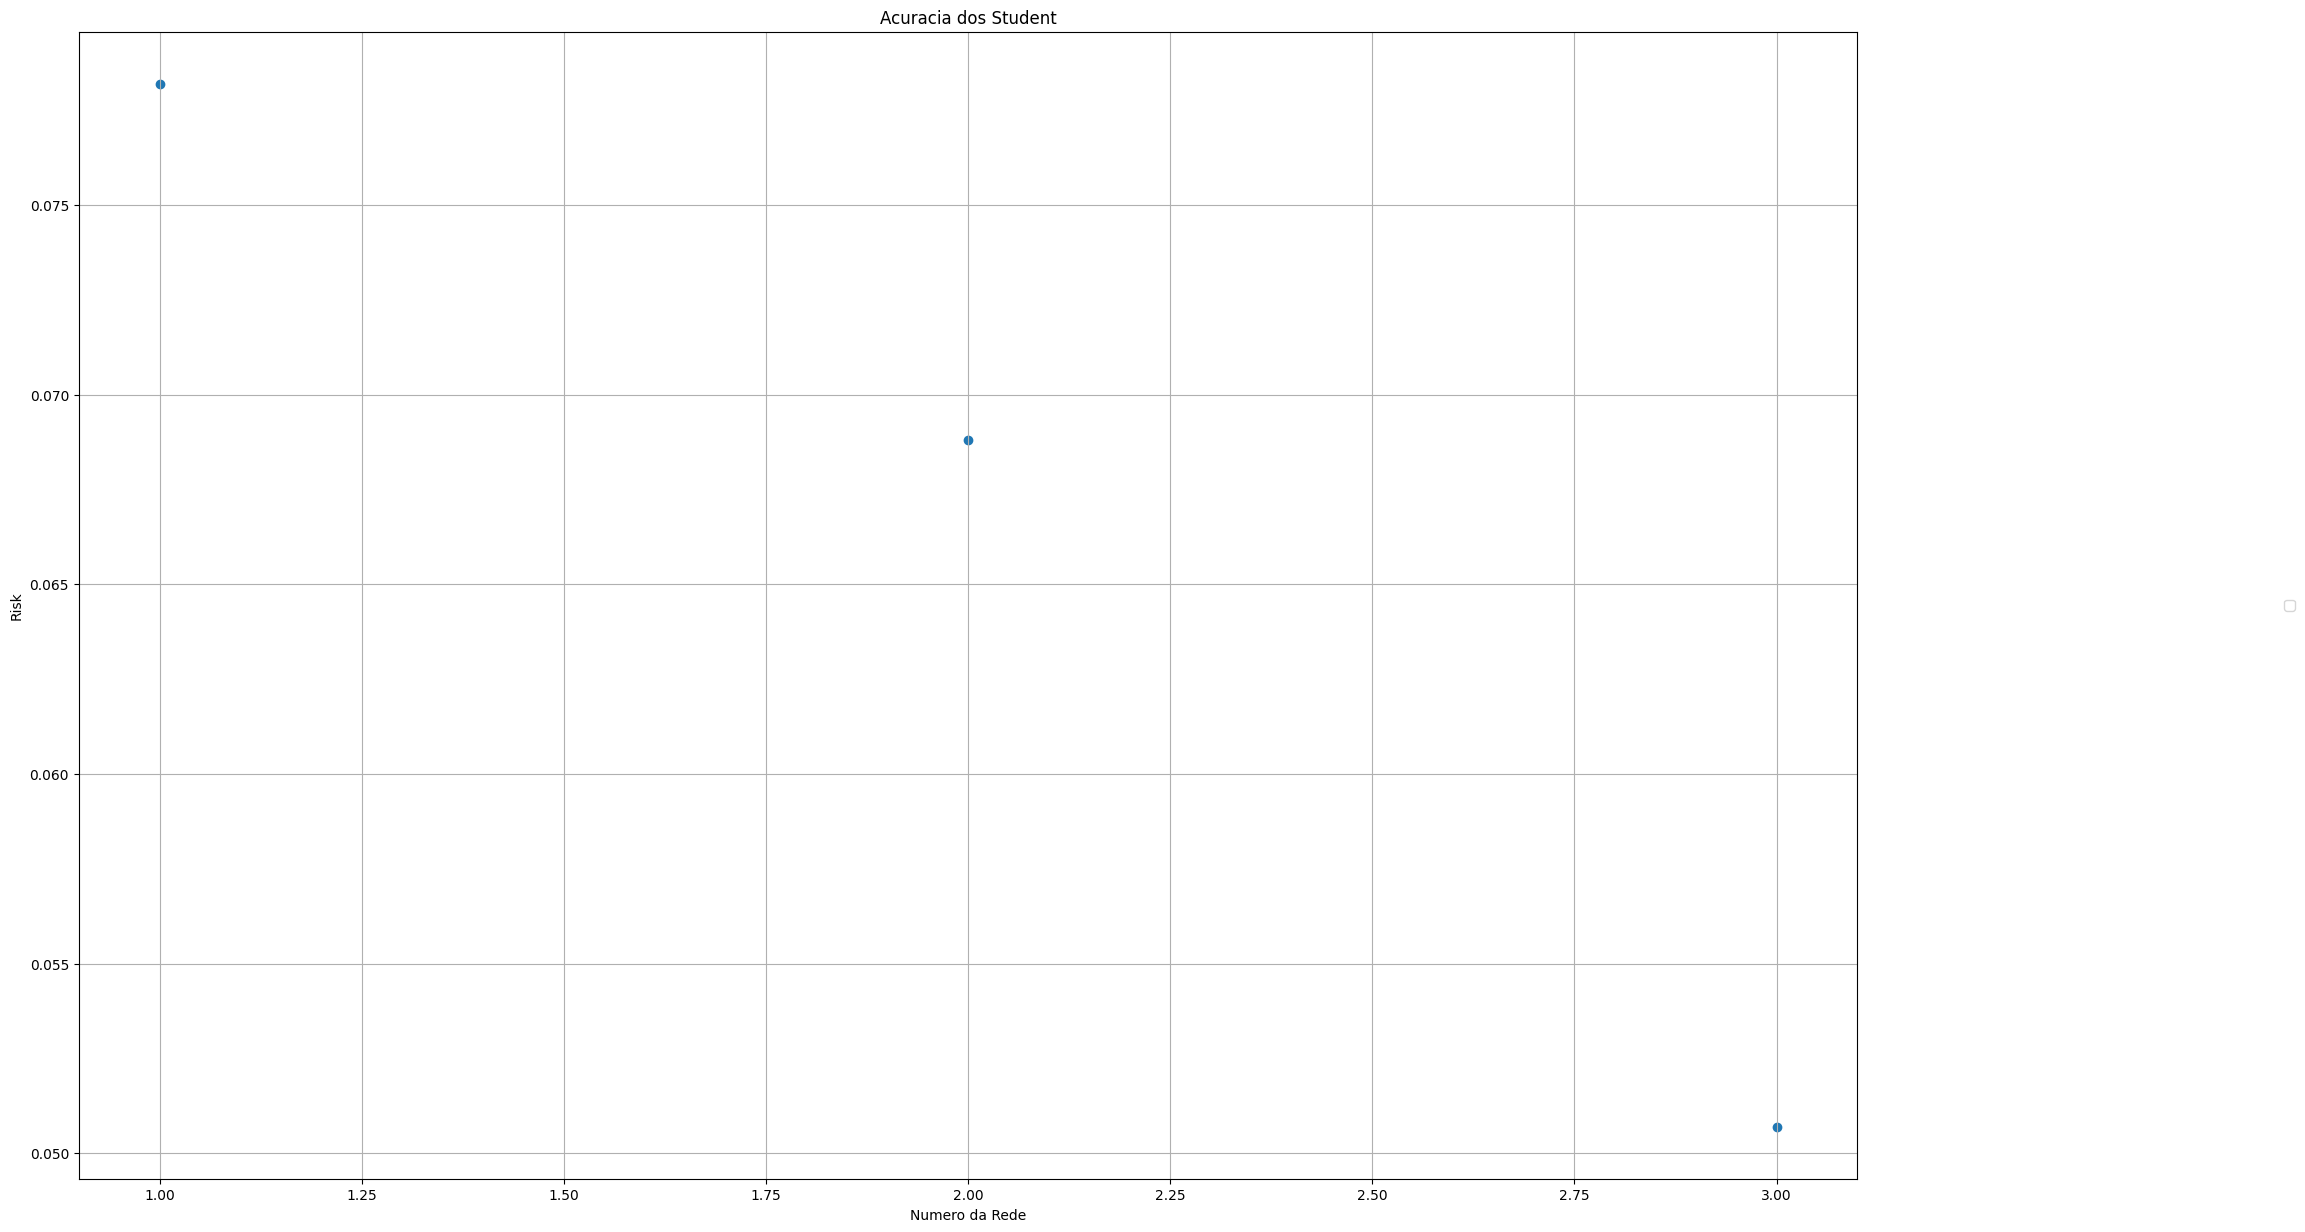

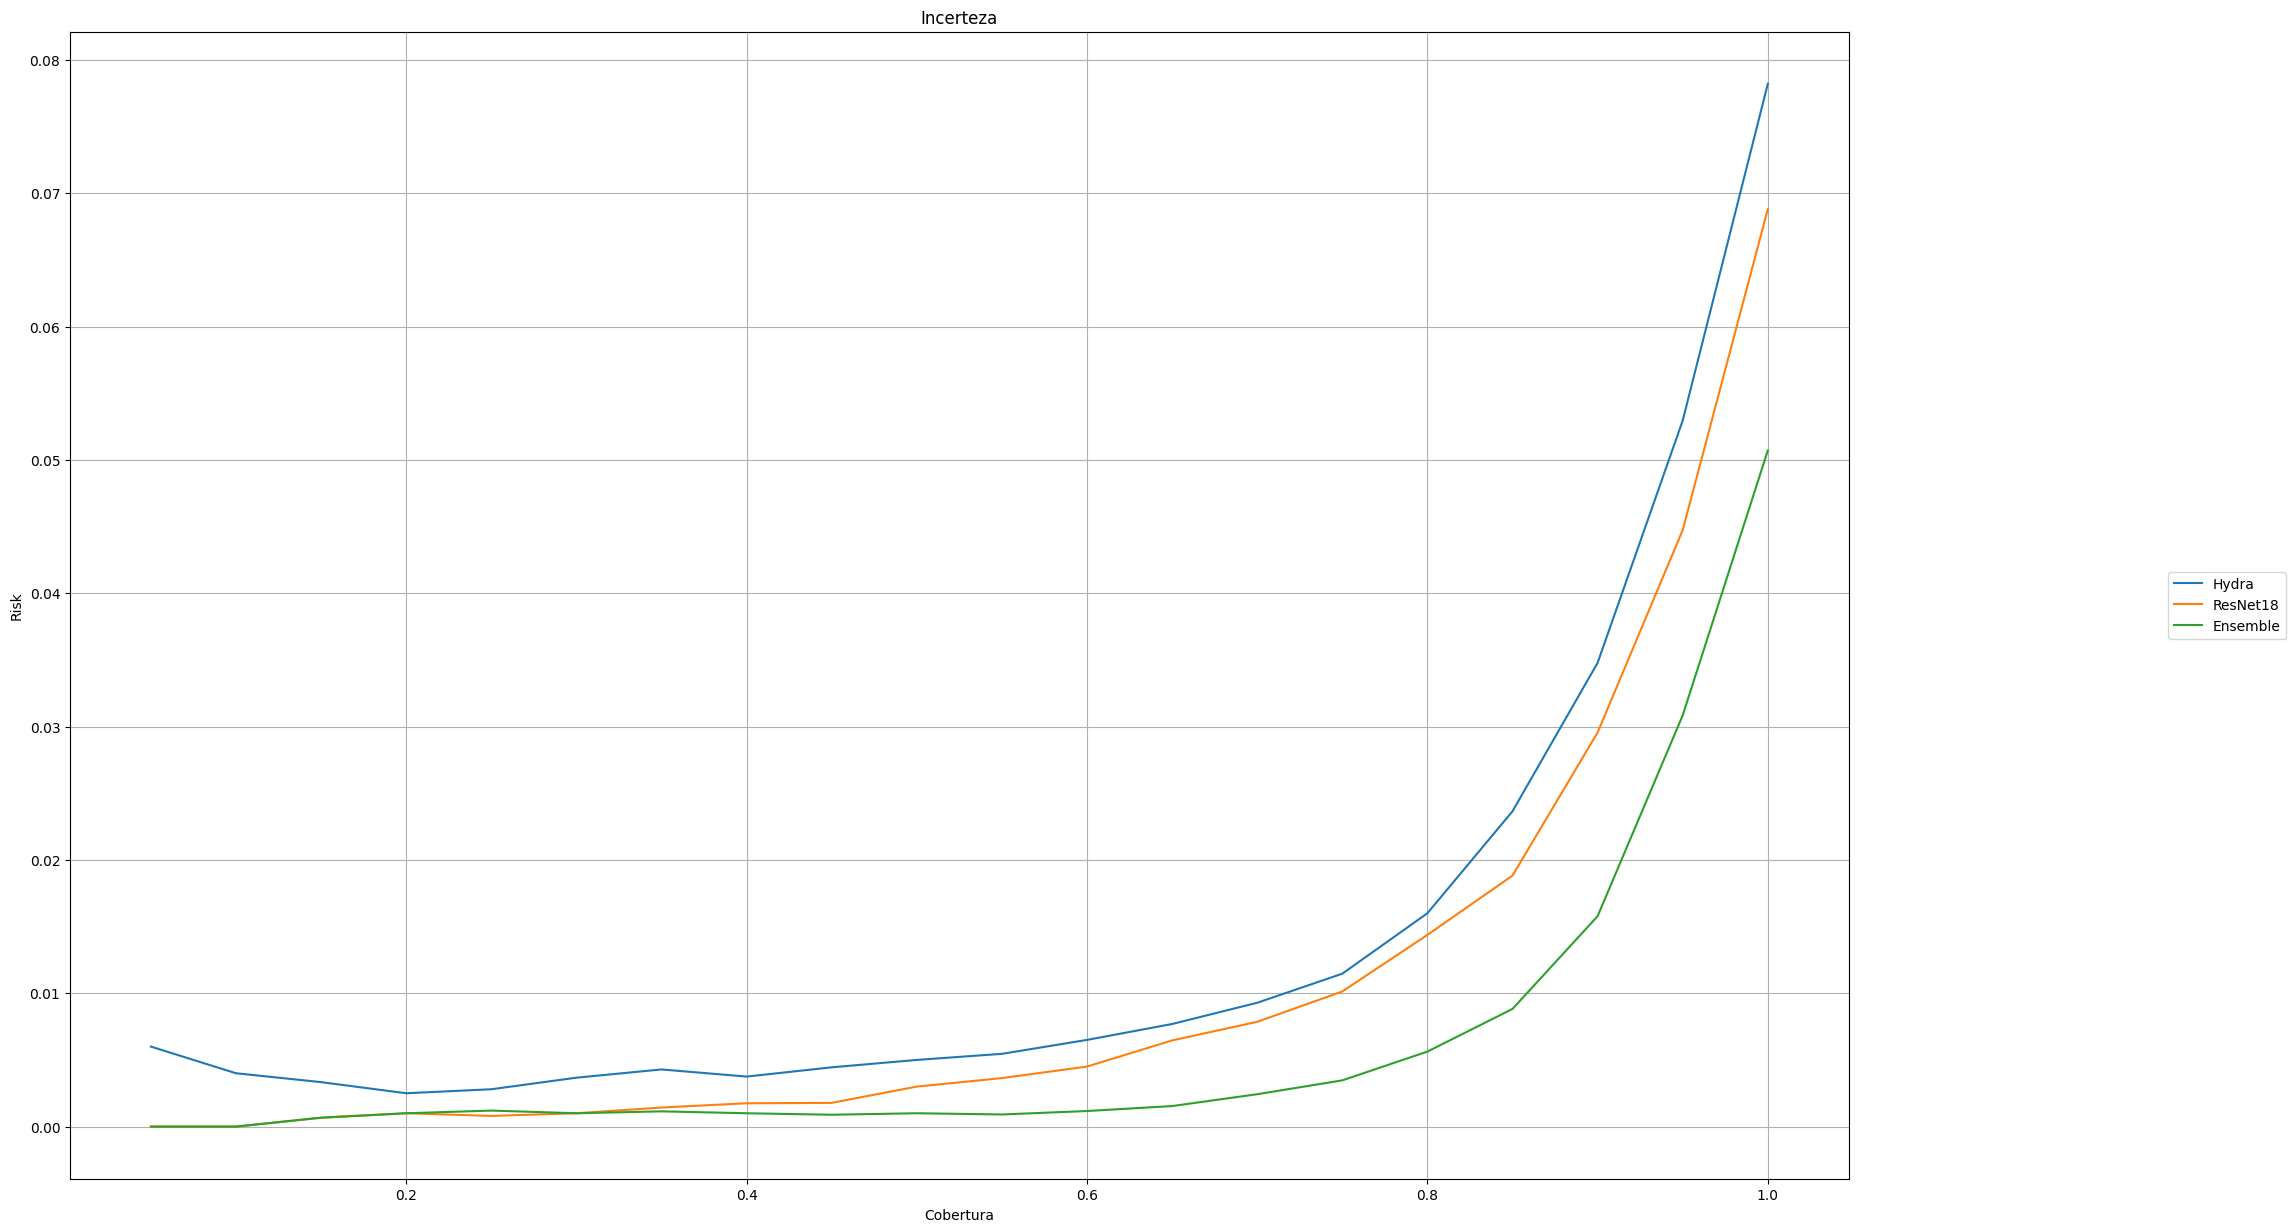

In [21]:
import matplotlib
import matplotlib.pyplot as plt

# Todosos graficos juntos
g1 = plot_graph(X = [1,2,3], Y = correct_list, title="Acuracia dos Student", xlabel="Numero da Rede",ylabel="Risk", line=False)

g2 = plot_mutiple_graph(X=np.arange(0.05,1.05,0.05),Y=covarege_list1,title="Incerteza",xlabel="Cobertura",ylabel="Risk",label="Hydra,ResNet18,Ensemble",multi_label=True,n_graphs=n_redes)

plt.show()

In [22]:
for i in range(num_cabeca):
    area_sobre_curva = auc(np.arange(0.05,1.05,0.05), covarege_list1[i])
    print((1-correct_list[i])*100, " ",area_sobre_curva)

92.17999999999999   0.01218257989258763
93.12   0.009295116061698878


In [ ]:
# TESTE ENSEMBLE

g1.savefig('./Graficos/Hydra/{}/{} Cabeças/Acuracia.png'.format(data_set,num_cabeca))
g2.savefig('./Graficos/Hydra/{}/{} Cabeças/Incerteza.png'.format(data_set,num_cabeca))

In [4]:
data_sets = ["Cifar10"]

acuracia_list = list()
auc_list = list()

for data_set in data_sets:
    if data_set == "Cifar10":
        transform_train, transform_test, batch_size, trainset, trainloader, testset, testloader, classes = cifar10()
    elif data_set == "Cifar100":
        transform_train, transform_test, batch_size, trainset, trainloader, testset, testloader= cifar100()
    acuracia_aux = list()
    auc_aux = list()
    for xx in range(2,16):    
        num_cabeca = xx # numero de cabecas da rede
        if data_set == "Cifar10":
            hydra = init_rede("Resnet_hydra", num_cabeca=num_cabeca) # Resnet_hydra ou Resnet100_hydra
        elif data_set == "Cifar100":
             hydra = init_rede("Resnet100_hydra", num_cabeca=num_cabeca) # Resnet_hydra ou Resnet100_hydra
        
        n_nets = num_cabeca

        #print("Loading Hydra")
        hydra = load_hydra(hydra, data_set,n_cabecas=num_cabeca)
        #students = load_teste_temp(students, data_set, temp)
        #print("End")


        #print("Loading Ensamble")
        nets_ensemble = load_resnet18(n_nets, data_set)
        #print("End")

        n_redes = 3 # Hydra + Ensemble + Resnet18

        # Calcula a acuracia da rede
        outputs = torch.tensor([]).to("cuda")
        outputs2 = torch.tensor([]).to("cuda")

        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for i, data in enumerate(testloader, 0):
                images, labels = data

                outputs_0 = caculate_outputs([hydra],images)
                outputs_0 = torch.stack(tuple(outputs_0),dim=0)
                outputs = torch.cat((outputs,outputs_0),dim=1)

        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for i, data in enumerate(testloader, 0):
                images, labels = data

                outputs_2 = caculate_outputs(nets_ensemble,images.to('cuda')) # cria uma lista onde cada index é o resultado de uma das redes
                outputs_2 = torch.stack(tuple(outputs_2),dim=0) # transfor a lista em um tensor [15,100,10]
                outputs2 = torch.cat((outputs2,outputs_2),dim=1) # junta os tensores na segunda dim ex: [15,100,10] -> [15,200,10]        

        ensamble_1_14 = torch.stack((outputs2[0], torch.mean(outputs2,dim=0)),dim=0) # Junta o primeiro ensamble com o ultimo
        outputs = torch.cat((outputs,ensamble_1_14),dim=0) # unta o primeiro ensamble com o ultimo com os students

        outputs = torch.nn.functional.softmax(outputs, dim=-1)

        predict_list = list()
        uncs_max_list = list()
        for i in range(n_redes):
            uncs_max, _, _, predict = calculate_predicted(outputs[i])
            predict_list.append(predict) # calcula a probabilidade de cada assemble
            uncs_max_list.append(uncs_max) # calcula a probabilidade de cada assemble

        predict_cat = torch.stack(tuple(predict_list),dim=0) # Junta as respostas
        uncs_max_cat = torch.stack(tuple(uncs_max_list),dim=0) # Junta as respostas

        images_cat = torch.tensor([])
        labels_cat = torch.tensor([])

        for i, data in enumerate(testloader, 0):
                images, labels = data
                images_cat = torch.cat((images_cat,images),dim=0) # Junta as respostas
                labels_cat = torch.cat((labels_cat,labels),dim=0) # Junta as respostas

        correct_list = list()
        covarege_list1 = list()
        for i in range(n_redes):
            correct_list.append(calculate_correct(predict_cat[i], labels_cat))
            covarege_list1.append(RC_curve(predict_cat[i],labels_cat.to("cuda"),uncs_max_cat[i]))

        # Todosos graficos juntos
        #g1 = plot_graph(X = [1,2,3], Y = correct_list, title="Acuracia dos Student", xlabel="Numero da Rede",ylabel="Risk", line=False)

        #g2 = plot_mutiple_graph(X=np.arange(0.05,1.05,0.05),Y=covarege_list1,title="Incerteza",xlabel="Cobertura",ylabel="Risk",label="Hydra,ResNet18,Ensemble",multi_label=True,n_graphs=n_redes)

        area_sobre_curva = auc(np.arange(0.05,1.05,0.05), covarege_list1[0])
        acuracia_aux.append(1-correct_list[0])
        auc_aux.append(area_sobre_curva)             

        # TESTE ENSEMBLE

        #g1.savefig('./Graficos/Hydra/{}/{} Cabeças/Acuracia.png'.format(data_set,num_cabeca))
        #g2.savefig('./Graficos/Hydra/{}/{} Cabeças/Incerteza.png'.format(data_set,num_cabeca))
        print(xx)
        
    acuracia_list.append(acuracia_aux)
    auc_list.append(auc_aux)

Files already downloaded and verified
Files already downloaded and verified
2
3
4
5
6
7
8
9
10
11
12
13
14
15
